In [1]:
from datetime import datetime as ddt

import numpy as np
import pandas as pd

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']

from matplotlib import pyplot as plt

from odps import ODPS
o = ODPS(access_id='',
         secret_access_key='',
         project='cashbus_etl',
         endpoint='http://service.cn.maxcompute.aliyun.com/api',
         tunnel_endpoint='http://dt.cn-beijing.maxcompute.aliyun.com')

In [20]:
def present_score(df,score,label_col=None,step_size=50):
    grouped_name = score+'_'+str(step_size)
    df_cp = df.copy()
    df_cp = df_cp[~df_cp[score].isnull()&(df_cp[score]>0)]
    df_cp[grouped_name] = df_cp[score].apply(lambda x: np.floor(float(x)/step_size)*step_size)

    def default_rate(x):
        return sum(x)/len(x)

    if not label_col:
        df_grouped = df_cp.groupby(grouped_name).agg({score:len}).reset_index()
        df_grouped.columns = ['range_min', 'count']
    else:
        df_cp = df_cp[~df_cp[label_col].isnull()]
        df_grouped = df_cp.groupby(grouped_name).agg({label_col:[len, lambda x: float(sum(x))/len(x)]}).reset_index()
        df_grouped.columns = ['range_min', 'count', 'default_rate']
    df_grouped['range_max'] = df_grouped['range_min'] + step_size
    df_grouped['range'] = df_grouped.apply(lambda row: '[{},{})'.format(int(row['range_min']),int(row['range_max'])), axis=1)
    df_grouped['perc'] = df_grouped['count']/df_grouped['count'].sum()
    df_grouped['perc_cumsum'] = df_grouped.ix[::-1,'perc'].cumsum()[::-1]

    if not label_col:
        rlt_df = df_grouped[['range','count','perc','perc_cumsum']]
    else:
        rlt_df = df_grouped[['range','count','perc','perc_cumsum','default_rate']]

    return rlt_df


In [9]:
# sql_expr = '''
# SELECT  *
# FROM    runid_gc_1000_to_1500
# WHERE   last_loanamount = 1000
# AND     last_loanstyle IN ('绿卡30天2期', '绿卡十万火急普通', '绿卡十万火急续期')
# ;
# '''

# with o.execute_sql(sql_expr).open_reader(limit_enabled=False) as reader:
#     df_gc = reader.to_pandas()

# df_gc.to_csv('runid_gc_1000_to_1500.csv', index=False)

In [10]:
df_gc = pd.read_csv('runid_gc_1000_to_1500.csv')
print(df_gc.shape)
df_gc.head()


(222974, 31)


,runid,created,userid,application,applicationid,rulesetid,action,isolduser,rulesetname,ruleid,...,last_loanstatus,last_payofftime,next_created,next_loanid,next_loanstyle,next_loandays,next_loanamount,next_loanstatus,next_payofftime,default_1_0
0,21191372,2018-12-20 14:36:25,2781025,cashbus.activate,25913220,656,reject,False,绿卡1500提额_第三方拒绝,5,...,Funded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21238735,2018-12-23 18:50:54,11603928,cashbus.activate,25960280,658,accept,False,绿卡1500提额_评分卡拒绝,15,...,PaidOff,2018-12-23 18:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21238407,2018-12-23 18:20:14,16503557,cashbus.activate,25959956,657,reject,False,绿卡1500提额_还款记录通过,10,...,Funded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21206847,2018-12-21 13:57:56,17424603,cashbus.activate,25928584,657,reject,False,绿卡1500提额_还款记录通过,10,...,PaidOff,2018-12-21 13:57:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21260766,2018-12-25 10:52:05,7889363,cashbus.activate,25982172,658,accept,False,绿卡1500提额_评分卡拒绝,15,...,PaidOff,2018-12-25 10:51:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_gc['date'] = df_gc.created.apply(lambda x: x[:10].replace('-',''))
df_gc['action_code'], action_index = pd.factorize(df_gc.action)
df_gc['rulesetname'] = df_gc.apply(
    lambda row: row.action if '评分卡' in row.rulesetname else row.rulesetname,
    axis=1)
df_gc['s920_creditlimit_bin'] = df_gc['s920_creditlimit'] // 50 * 50
df_gc['s920_2000creditlimit_bin'] = df_gc['s920_2000creditlimit'] // 50 * 50
df_gc['last_loanstyle'] = df_gc.last_loanstyle.apply(lambda x: '绿卡十万火急' if '绿卡十万火急' in x else x)

In [12]:
df_gc.groupby('last_loanstyle').agg({'action_code': np.mean})


,action_code
last_loanstyle,
绿卡30天2期,0.151724
绿卡十万火急,0.081332


In [13]:
pass_reject_ratio_by_date = pd.get_dummies(
    df_gc[['date', 'last_loanstyle', 'rulesetname']], 
    columns=['rulesetname']).groupby(['last_loanstyle', 'date']).mean().reset_index()
pass_reject_ratio_by_date.columns = ['last_loanstyle', 'date', 'accept', 'reject', 'grey', 'thirdparty', 'payoff']
pass_reject_ratio_by_date.head()


,last_loanstyle,date,accept,reject,grey,thirdparty,payoff
0,绿卡30天2期,20181212,0.172070,0.253117,0.016209,0.112219,0.446384
1,绿卡30天2期,20181213,0.151092,0.270742,0.015721,0.100437,0.462009
2,绿卡30天2期,20181214,0.166796,0.300233,0.020171,0.089216,0.423584
3,绿卡30天2期,20181215,0.155521,0.272162,0.022551,0.086314,0.463453
4,绿卡30天2期,20181216,0.164889,0.269893,0.022970,0.087777,0.454471


绿卡30天2期
绿卡十万火急


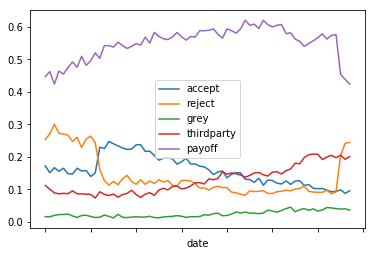

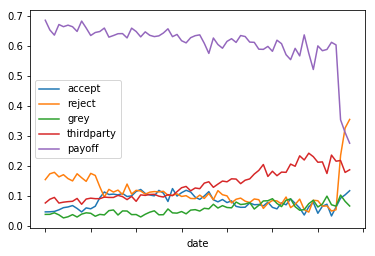

In [14]:
for level, group in pass_reject_ratio_by_date.groupby('last_loanstyle'):
    print(level)
    group.plot('date')


In [32]:
df_gc['new_pass'] = df_gc.apply(lambda row: 'pass' if row.f701<=10 and row.f702>=3 and row.f901>=60 and row.f902>=200 else 'fail', axis = 1)


In [33]:
new_check = df_gc[df_gc.rulesetname.isin(['accept', 'reject', '绿卡1500提额_还款记录通过']) & (df_gc.new_pass == 'pass')]

In [34]:
present_score(df_gc, 's920_creditlimit_bin', 'default_1_0')

/Users/liuqing/vEnv/py3_general/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,range,count,perc,perc_cumsum,default_rate
0,"[400,450)",1.0,0.000023,1.000000,1.000000
1,"[450,500)",2.0,0.000046,0.999977,0.500000
2,"[500,550)",4.0,0.000091,0.999932,0.750000
3,"[550,600)",26.0,0.000592,0.999841,0.461538
4,"[600,650)",40.0,0.000911,0.999248,0.650000
5,"[650,700)",112.0,0.002551,0.998338,0.607143
6,"[700,750)",275.0,0.006263,0.995787,0.621818
7,"[750,800)",871.0,0.019836,0.989524,0.599311
8,"[800,850)",2420.0,0.055113,0.969688,0.547107
9,"[850,900)",7583.0,0.172694,0.914575,0.469867


In [35]:
present_score(new_check, 's920_creditlimit_bin', 'default_1_0')

/Users/liuqing/vEnv/py3_general/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,range,count,perc,perc_cumsum,default_rate
0,"[500,550)",2.0,0.000109,1.000000,1.000000
1,"[550,600)",7.0,0.000381,0.999891,0.571429
2,"[600,650)",14.0,0.000762,0.999510,0.500000
3,"[650,700)",52.0,0.002832,0.998748,0.557692
4,"[700,750)",144.0,0.007841,0.995916,0.625000
5,"[750,800)",436.0,0.023742,0.988074,0.536697
6,"[800,850)",1246.0,0.067850,0.964332,0.522472
7,"[850,900)",3698.0,0.201372,0.896482,0.450784
8,"[900,950)",8479.0,0.461719,0.695110,0.344616
9,"[950,1000)",4286.0,0.233391,0.233391,0.210219
